<a href="https://colab.research.google.com/github/MaxiRome/datasets/blob/main/Tarea_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Maximiliano Romero

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [31]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Subir datasets de dígitos (train)

In [32]:
!wget https://github.com/MaxiRome/datasets/raw/main/1_digits_train.txt
!wget https://github.com/MaxiRome/datasets/raw/main/1_digits_test.txt

--2023-10-29 01:18:21--  https://github.com/MaxiRome/datasets/raw/main/1_digits_train.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxiRome/datasets/main/1_digits_train.txt [following]
--2023-10-29 01:18:21--  https://raw.githubusercontent.com/MaxiRome/datasets/main/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt.2’

1_digits_train.txt. 100%[===================>] 625.59K  --.-KB/s    in 0.06s   

2023-10-29 01:18:21 (9.98 MB/s) - ‘1_digits_train.txt.2’ saved [640604/640604]

--2023-10-29 01:18:21--  https://githu

## Leer dataset de dígitos

In [33]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [34]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [35]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [36]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [37]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-37-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-37-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-37-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if colu

In [38]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear datasets y dataloaders para pytorch (train)

In [39]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [40]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [41]:
# Función para crear y entrenar la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_function):
        super(NeuralNetwork, self).__init__()
        if hidden_size2 is not None:  # si aparece otra capa oculta crea una red con 2 capas ocultas
            self.layers = nn.Sequential(
                nn.Linear(input_size, hidden_size1),
                activation_function,  # Funcion de activacion
                nn.Linear(hidden_size1, hidden_size2),
                activation_function,
                nn.Linear(hidden_size2, output_size)
            )
        else:
            self.layers = nn.Sequential(    # Si no aparece otra capa oculta crea una red con solo una capa oculta
                nn.Linear(input_size, hidden_size1),
                activation_function,
                nn.Linear(hidden_size1, output_size)
            )

    def forward(self, x):  # Propagacion hacia adelante a traves de las capas de la red
        return self.layers(x)

# Tamaño de lotes de datos y numero de epocas antes de overfitting
batch_size = 128
overfitting = 15

# Función para entrenar el modelo con un conjunto de datos de entrenamiento y validación
def train_model(model, dataloader_train, dataloader_val):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Mueve el modelo a GPU

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_validation_loss = float('inf')
    epochs_without_improvement = 0

    loss_train = []  # Almacena la perdida de entrenamiento
    loss_val = []    # Almacena la perdida de validacion

    start = time.time() # Tiempo de inicio del entrenamiento

    for epoch in range(1000):   # Bucle de entrenamiento con un máximo de 1000 épocas
        loss_train_batches = [] # Lista para almacenar la pérdida en lotes de entrenamiento
        loss_val_batches = []   # Lista para almacenar la pérdida en lotes de validación


        model.train() # Establece el modelo en modo de entrenamiento
        for i, data in enumerate(dataloader_train, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train_batches.append(loss.item())

        loss_train.append(np.mean(loss_train_batches))

        model.eval() # Establece el modelo en modo de evaluación
        with torch.no_grad():
            for i, data in enumerate(dataloader_val, 0):
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_val_batches.append(loss.item())

        loss_val.append(np.mean(loss_val_batches))

        print("Epoch: %d, train loss: %.4f, val loss: %.4f" % (epoch, loss_train[epoch], loss_val[epoch]))

        if loss_val[epoch] < best_validation_loss:
            best_validation_loss = loss_val[epoch]
            torch.save(model.state_dict(), 'best_model_checkpoint.pth')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= overfitting:
            break

    end = time.time() # Registra el tiempo de finalización del entrenamiento
    print('Finished Training, total time %f seconds' % (end - start))

    return loss_train, loss_val

# Función para graficar la pérdida de entrenamiento y validación
def plot_loss(epochs, loss_train, loss_val):
    plt.figure(figsize=(8, 5))
    plt.title('Gráfico del loss de entrenamiento y el de validación en función del tiempo')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.plot(epochs, loss_train, 'purple', label='Entrenamiento')
    plt.plot(epochs, loss_val, 'blue', label='Validación')
    plt.grid()
    plt.legend()
    plt.show()

# Función para evaluar el modelo en un conjunto de datos de prueba
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for i, data in enumerate(dataloader, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions, normalize='true') # Calcula la matriz de confusión
    accuracy = accuracy_score(all_labels, all_predictions) # Calcula la precisión del modelo

    disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_labels)) # Visualiza la matriz de confusión
    disp = disp.plot(cmap="viridis", values_format='.2f')

    print("Precisión: ", accuracy)

Epoch: 0, train loss: 2.2613, val loss: 2.1547
Epoch: 1, train loss: 2.0701, val loss: 1.9480
Epoch: 2, train loss: 1.8532, val loss: 1.7117
Epoch: 3, train loss: 1.6144, val loss: 1.4675
Epoch: 4, train loss: 1.3799, val loss: 1.2402
Epoch: 5, train loss: 1.1679, val loss: 1.0521
Epoch: 6, train loss: 0.9828, val loss: 0.8934
Epoch: 7, train loss: 0.8251, val loss: 0.7421
Epoch: 8, train loss: 0.6975, val loss: 0.6295
Epoch: 9, train loss: 0.5979, val loss: 0.5465
Epoch: 10, train loss: 0.5201, val loss: 0.4709
Epoch: 11, train loss: 0.4591, val loss: 0.4339
Epoch: 12, train loss: 0.4116, val loss: 0.3876
Epoch: 13, train loss: 0.3714, val loss: 0.3612
Epoch: 14, train loss: 0.3393, val loss: 0.3302
Epoch: 15, train loss: 0.3125, val loss: 0.3001
Epoch: 16, train loss: 0.2912, val loss: 0.2884
Epoch: 17, train loss: 0.2721, val loss: 0.2599
Epoch: 18, train loss: 0.2546, val loss: 0.2535
Epoch: 19, train loss: 0.2404, val loss: 0.2505
Epoch: 20, train loss: 0.2273, val loss: 0.2319
Ep

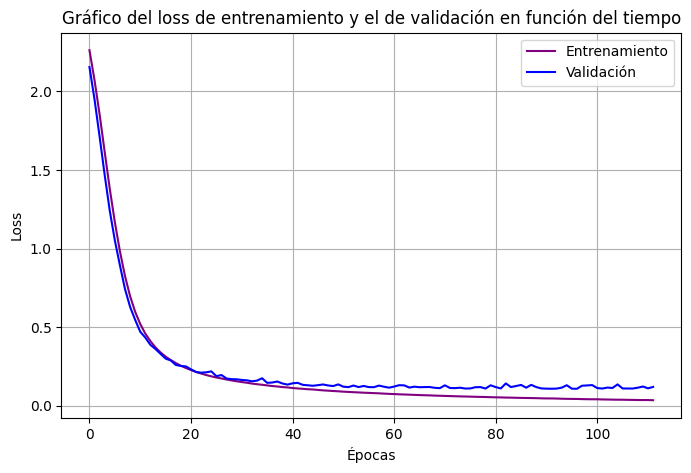

Precisión:  0.9655172413793104
Precisión:  0.9957264957264957


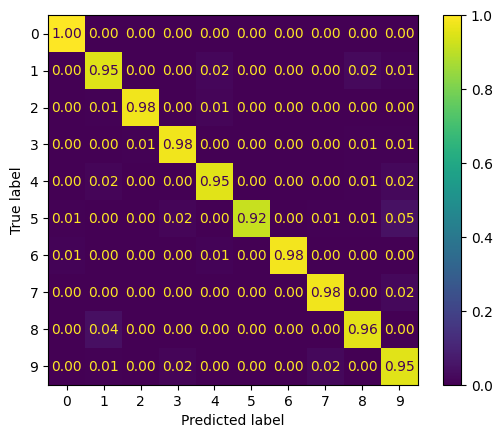

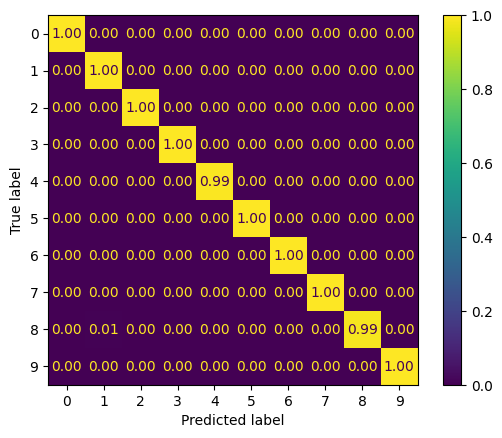

In [53]:
Class1 = NeuralNetwork(input_size=64, hidden_size1=10, hidden_size2=None, output_size=10, activation_function=nn.ReLU())
loss_train1, loss_val1 = train_model(Class1, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(Class1, dataloader_val)
evaluate_model(Class1, dataloader_train)

In [ ]:
Class2 = NeuralNetwork(input_size=64, hidden_size1=40, hidden_size2=None, output_size=10, activation_function=nn.ReLU())
loss_train1, loss_val1 = train_model(Class2, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(Class2, dataloader_val)
evaluate_model(Class2, dataloader_train)

Epoch: 0, train loss: 2.2455, val loss: 2.1022
Epoch: 1, train loss: 1.9872, val loss: 1.8691
Epoch: 2, train loss: 1.7810, val loss: 1.6804
Epoch: 3, train loss: 1.6080, val loss: 1.5351
Epoch: 4, train loss: 1.4590, val loss: 1.3739
Epoch: 5, train loss: 1.3263, val loss: 1.2503
Epoch: 6, train loss: 1.2084, val loss: 1.1358
Epoch: 7, train loss: 1.1013, val loss: 1.0370
Epoch: 8, train loss: 1.0074, val loss: 0.9431
Epoch: 9, train loss: 0.9212, val loss: 0.8755
Epoch: 10, train loss: 0.8454, val loss: 0.7948
Epoch: 11, train loss: 0.7786, val loss: 0.7512
Epoch: 12, train loss: 0.7187, val loss: 0.6783
Epoch: 13, train loss: 0.6656, val loss: 0.6521
Epoch: 14, train loss: 0.6187, val loss: 0.5927
Epoch: 15, train loss: 0.5772, val loss: 0.5583
Epoch: 16, train loss: 0.5401, val loss: 0.5271
Epoch: 17, train loss: 0.5085, val loss: 0.4924
Epoch: 18, train loss: 0.4781, val loss: 0.4692
Epoch: 19, train loss: 0.4515, val loss: 0.4514
Epoch: 20, train loss: 0.4283, val loss: 0.4237
Ep

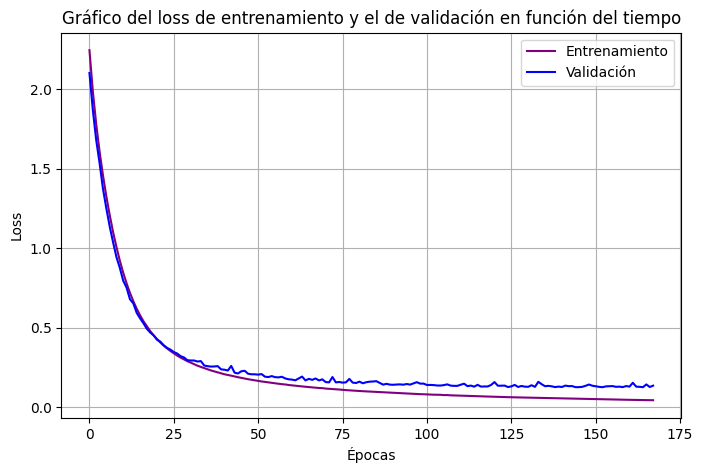

Precisión:  0.9616858237547893
Precisión:  0.9937541091387245


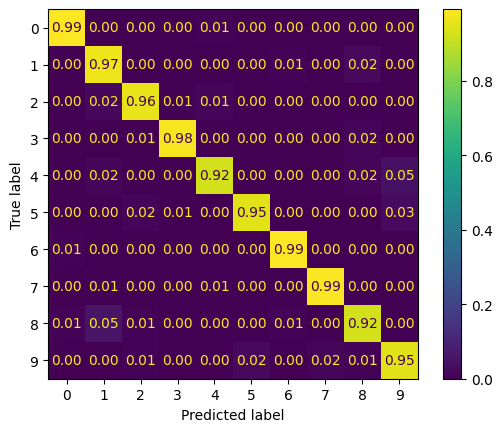

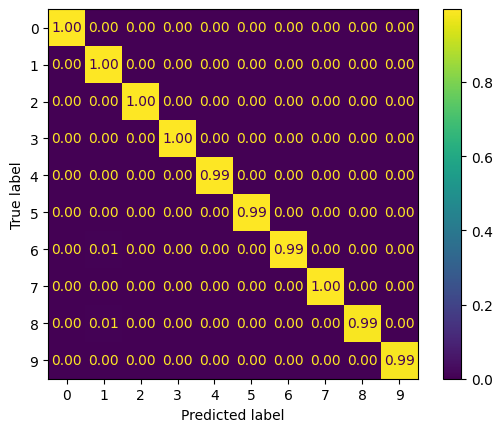

In [54]:
Class3= NeuralNetwork(input_size=64, hidden_size1=10, hidden_size2=None, output_size=10, activation_function=nn.Tanh())
loss_train1, loss_val1 = train_model(Class3, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(Class3, dataloader_val)
evaluate_model(Class3, dataloader_train)

Epoch: 0, train loss: 2.0707, val loss: 1.7647
Epoch: 1, train loss: 1.5489, val loss: 1.3134
Epoch: 2, train loss: 1.1531, val loss: 0.9742
Epoch: 3, train loss: 0.8637, val loss: 0.7376
Epoch: 4, train loss: 0.6607, val loss: 0.5732
Epoch: 5, train loss: 0.5192, val loss: 0.4559
Epoch: 6, train loss: 0.4208, val loss: 0.3911
Epoch: 7, train loss: 0.3535, val loss: 0.3315
Epoch: 8, train loss: 0.3036, val loss: 0.2935
Epoch: 9, train loss: 0.2677, val loss: 0.2475
Epoch: 10, train loss: 0.2390, val loss: 0.2387
Epoch: 11, train loss: 0.2156, val loss: 0.2085
Epoch: 12, train loss: 0.1974, val loss: 0.2065
Epoch: 13, train loss: 0.1822, val loss: 0.1888
Epoch: 14, train loss: 0.1690, val loss: 0.1759
Epoch: 15, train loss: 0.1596, val loss: 0.1622
Epoch: 16, train loss: 0.1486, val loss: 0.1555
Epoch: 17, train loss: 0.1398, val loss: 0.1535
Epoch: 18, train loss: 0.1324, val loss: 0.1396
Epoch: 19, train loss: 0.1250, val loss: 0.1400
Epoch: 20, train loss: 0.1191, val loss: 0.1410
Ep

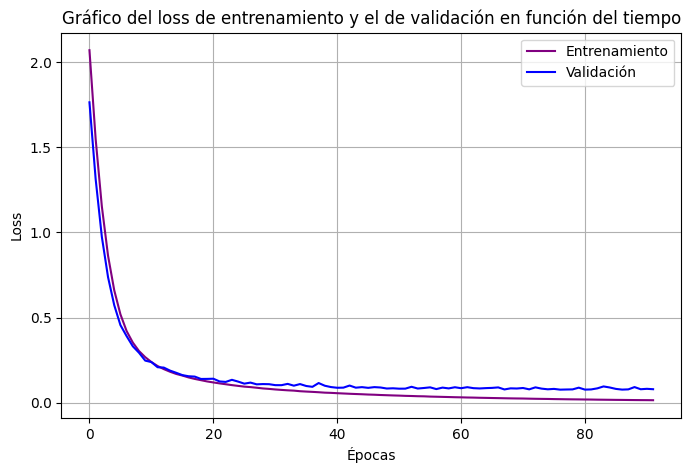

Precisión:  0.9724137931034482
Precisión:  0.9996712689020382


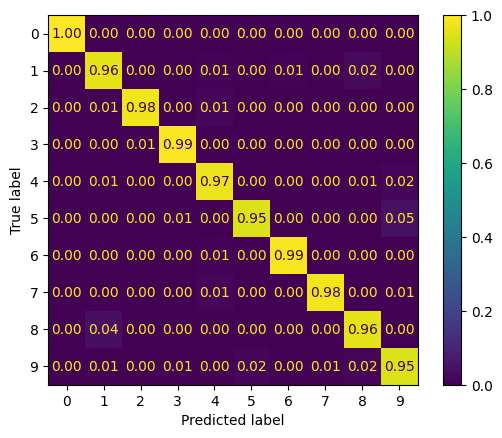

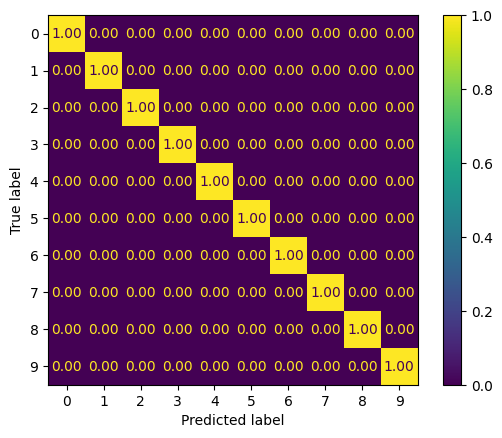

In [55]:
Class4 = NeuralNetwork(input_size=64, hidden_size1=40, hidden_size2=None, output_size=10, activation_function=nn.Tanh())
loss_train1, loss_val1 = train_model(Class4, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(Class4, dataloader_val)
evaluate_model(Class4, dataloader_train)

In [ ]:
Class5 = NeuralNetwork(input_size=64, hidden_size1=10, hidden_size2=10, output_size=10, activation_function=nn.ReLU())
loss_train1, loss_val1 = train_model(Class5, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(Class5, dataloader_val)
evaluate_model(Class5, dataloader_train)

In [ ]:
Class6 = NeuralNetwork(input_size=64, hidden_size1=40, hidden_size2=40, output_size=10, activation_function=nn.ReLU())
loss_train1, loss_val1 = train_model(Class6, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(Class6, dataloader_val)
evaluate_model(Class6, dataloader_train)